## TensorRT
TensorRT is a library delivered by NVIDIA.

It allows for efficient inference computation of neural networks models.

Library delivers many tools like model optimization or pruning.

Access to mentioned functionality is available for may popular DNN frameworks like PyTorch or Tensor-Flow.

Presented notebook shows usage of library on the example of semantic segmentation.

The goal of semantic segmentation is to assign a class (in some cases classes) for each pixel of image.

Pixels that are the part of the object(s) of the same type/class should have the same class.

For that task for a single image we need to assign array of the same size with class ids or 

n boolean arrays - each represents separate class.     

Your task is to design Deep Neural Network architecture to achieve 

Binary Accuracy metric higher than 0.99 on validation dataset.


Helpful links:
- U-net https://arxiv.org/pdf/1505.04597v1.pdf
- Semantic segmentation datasets - https://paperswithcode.com/task/semantic-segmentation
- Autoencoders - https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798
- Autoencoders - https://en.wikipedia.org/wiki/Autoencoder

Install required packages (if not installed):

In [1]:
! pip install nvidia-pyindex nvidia-tensorrt tensorflow
! pip install torch-tensorrt==1.3.0 --find-links https://github.com/pytorch/TensorRT/releases/expanded_assets/v1.3.0
! pip install git+https://github.com/LukeTonin/simple-deep-learning --no-deps

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in links: https://github.com/pytorch/TensorRT/releases/expanded_assets/v1.3.0
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/LukeTonin/simple-deep-learning to /tmp/pip-req-build-h3upvkst
  Running command git clone --filter=blob:none --quiet https://github.com/LukeTonin/simple-deep-learning /tmp/pip-req-build-h3upvkst
  Resolved https://github.com/LukeTonin/simple-deep-learning to commit 18005bf4cfe0d67470a0b80b763fb0565c8cfcac
  Preparing metadata (setup.py) ... done


In [2]:
from simple_deep_learning.mnist_extended.semantic_segmentation import create_semantic_segmentation_dataset
import matplotlib.pyplot as plt
import numpy as np
import torch
import local_utils as lu

2023-01-19 14:40:21.058929: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 14:40:22.698925: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-19 14:40:22.699081: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-19 14:40:22.699100: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [3]:
BATCH_SIZE = 32
NUM_OF_CLASSES = 10
NUM_OF_TRAINING_SAMPLES = BATCH_SIZE * 32
NUM_OF_TEST_SAMPLES = BATCH_SIZE * 4
INPUT_WIDTH = 64
INPUT_HEIGHT = 64
INPUT_CHANNELS = 1
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [4]:
np.random.seed(0)
train_x, train_y, _, _ = create_semantic_segmentation_dataset(NUM_OF_TRAINING_SAMPLES, 1, (INPUT_WIDTH, INPUT_HEIGHT), 2, 9, NUM_OF_CLASSES, 0.1)
np.random.seed(5)
_, _, test_x, test_y = create_semantic_segmentation_dataset(1, NUM_OF_TEST_SAMPLES, (INPUT_WIDTH, INPUT_HEIGHT), 2, 9, NUM_OF_CLASSES, 0.1)
train_x = torch.from_numpy(np.moveaxis(train_x,-1, 1)).to(torch.float32)
train_y = torch.from_numpy(np.moveaxis(train_y,-1, 1)).to(torch.float32)
test_x = torch.from_numpy(np.moveaxis(test_x,-1, 1)).to(torch.float32)
test_y = torch.from_numpy(np.moveaxis(test_y,-1, 1)).to(torch.float32)
print(train_y.shape)
print(train_x.shape)
print(test_y.shape)
print(test_x.shape)

train_loader = lu.CustomDataLoader(train_x, train_y, batch_size=BATCH_SIZE)
test_loader = lu.CustomDataLoader(test_x, test_y, batch_size=BATCH_SIZE)
eval_loader = lu.CustomDataLoader(test_x, test_y, batch_size=1)

torch.Size([1024, 10, 64, 64])
torch.Size([1024, 1, 64, 64])
torch.Size([128, 10, 64, 64])
torch.Size([128, 1, 64, 64])


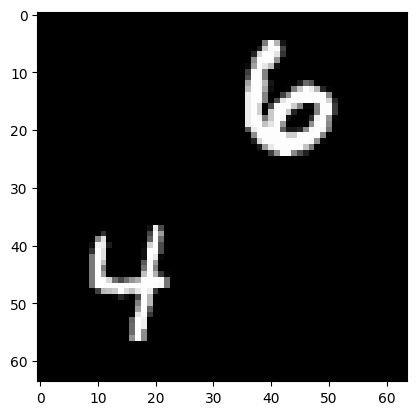

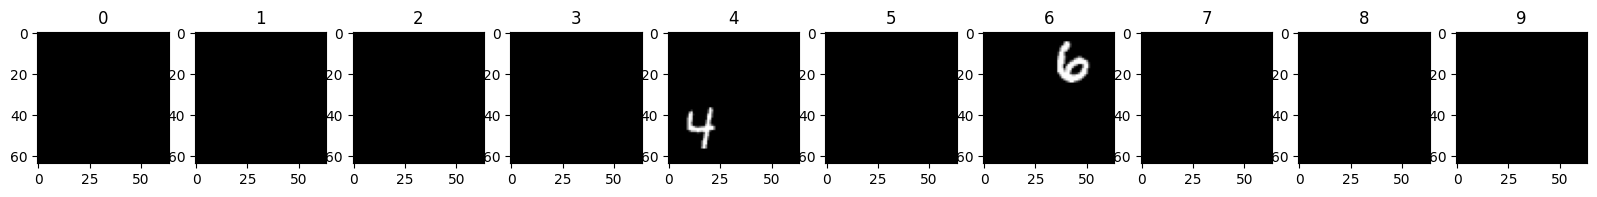

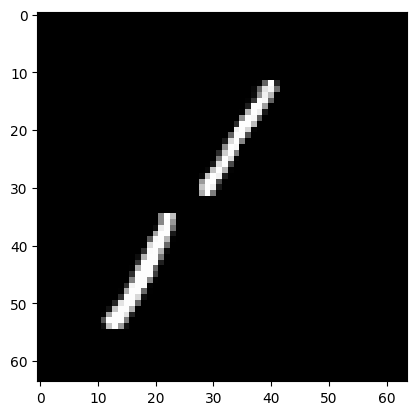

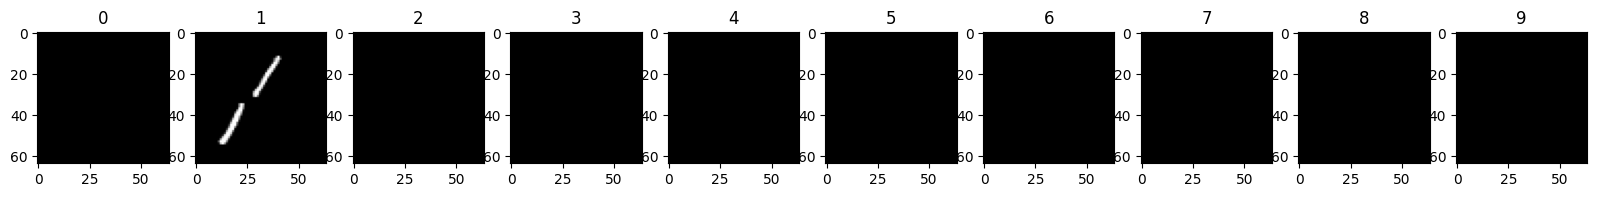

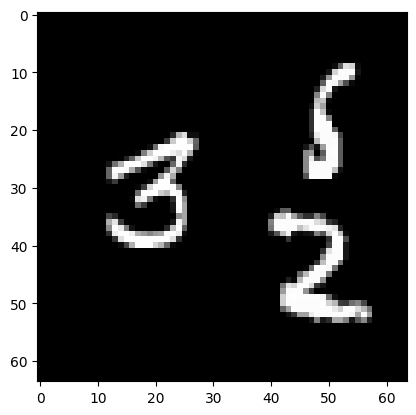

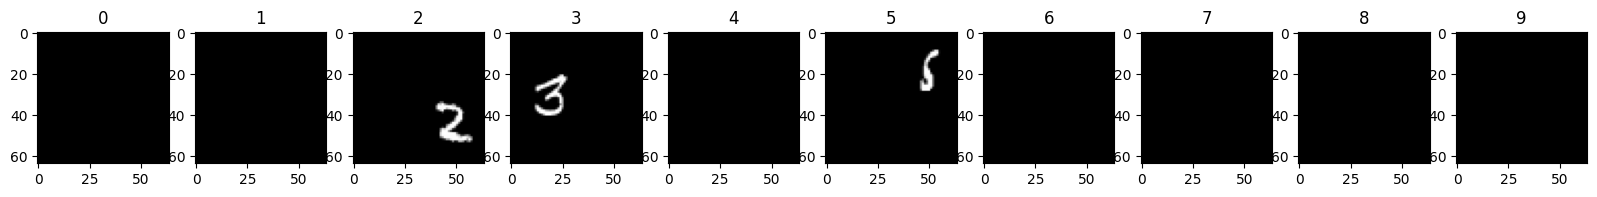

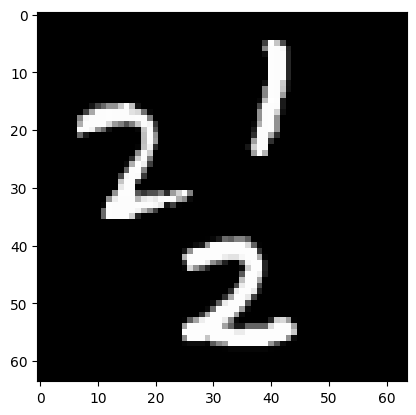

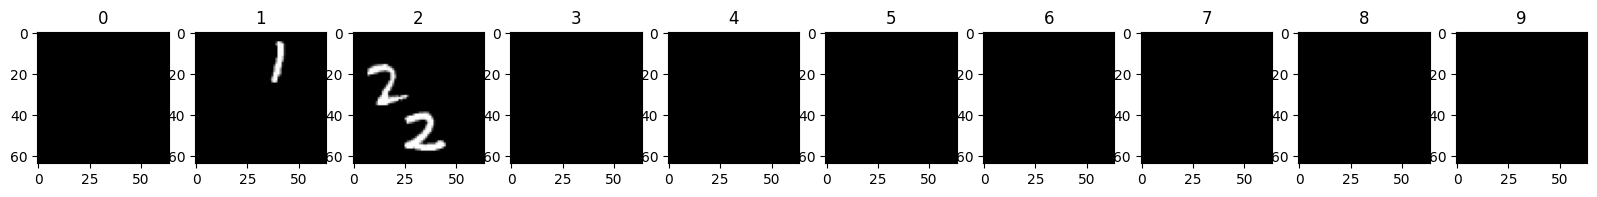

In [5]:
for X, Y in train_loader:
    for i in range(min(4, train_loader.batch_size)):
        plt.gray()
        plt.imshow(X[i][0])
        plt.show()
        fig, axes = plt.subplots(1, Y[i].shape[0], figsize=(20,2))
        axes = np.array(axes).flatten().tolist()
        for cls, (a, y) in enumerate(zip(axes, Y[i])):
            a.imshow(y)
            a.set_title(str(cls))
        plt.show()
    break

In [6]:
criterion = lu.BinaryCrossEntropyLoss(1)
metric = lu.BinaryAccuracy()

# DEFINE HERE YOUR MODEL :)
net = lu.UNet(INPUT_CHANNELS, NUM_OF_CLASSES, True)
# net = lu.SimpleSegmenter((INPUT_CHANNELS, INPUT_HEIGHT, INPUT_WIDTH), num_of_classes=NUM_OF_CLASSES)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [7]:
net, history = lu.training(net,
                           train_loader,
                           test_loader,
                           criterion,
                           metric,
                           optimizer,
                           update_period=2,
                           epoch_max=60,
                           device=device)
lu.plot_history(history)

Epoch 1 / 60: STARTED
TRAINING
Running on platform: Linux-5.15.0-58-generic-x86_64-with-glibc2.35, machine: x86_64, python_version: 3.10.6, processor: x86_64, system: Linux, 


100%|██████████| 32/32 [00:28<00:00,  1.12it/s]


VALIDATION
Running on platform: Linux-5.15.0-58-generic-x86_64-with-glibc2.35, machine: x86_64, python_version: 3.10.6, processor: x86_64, system: Linux, 


100%|██████████| 4/4 [00:00<00:00,  7.42it/s]


After epoch 1: loss=0.7078 metric=0.6411 val_loss=0.6780 val_metric=0.7463
Epoch 1 / 60: FINISHED

Epoch 2 / 60: STARTED
TRAINING
Running on platform: Linux-5.15.0-58-generic-x86_64-with-glibc2.35, machine: x86_64, python_version: 3.10.6, processor: x86_64, system: Linux, 


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


VALIDATION
Running on platform: Linux-5.15.0-58-generic-x86_64-with-glibc2.35, machine: x86_64, python_version: 3.10.6, processor: x86_64, system: Linux, 


100%|██████████| 4/4 [00:00<00:00,  7.54it/s]


After epoch 2: loss=0.6776 metric=0.7203 val_loss=0.6654 val_metric=0.7481
Epoch 2 / 60: FINISHED

Epoch 3 / 60: STARTED
TRAINING
Running on platform: Linux-5.15.0-58-generic-x86_64-with-glibc2.35, machine: x86_64, python_version: 3.10.6, processor: x86_64, system: Linux, 


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


VALIDATION
Running on platform: Linux-5.15.0-58-generic-x86_64-with-glibc2.35, machine: x86_64, python_version: 3.10.6, processor: x86_64, system: Linux, 


100%|██████████| 4/4 [00:00<00:00,  7.60it/s]


After epoch 3: loss=0.6591 metric=0.7645 val_loss=0.6519 val_metric=0.7884
Epoch 3 / 60: FINISHED

Epoch 4 / 60: STARTED
TRAINING
Running on platform: Linux-5.15.0-58-generic-x86_64-with-glibc2.35, machine: x86_64, python_version: 3.10.6, processor: x86_64, system: Linux, 


100%|██████████| 32/32 [00:25<00:00,  1.27it/s]


VALIDATION
Running on platform: Linux-5.15.0-58-generic-x86_64-with-glibc2.35, machine: x86_64, python_version: 3.10.6, processor: x86_64, system: Linux, 


100%|██████████| 4/4 [00:00<00:00,  8.03it/s]


After epoch 4: loss=0.6448 metric=0.8022 val_loss=0.6390 val_metric=0.8230
Epoch 4 / 60: FINISHED

Epoch 5 / 60: STARTED
TRAINING
Running on platform: Linux-5.15.0-58-generic-x86_64-with-glibc2.35, machine: x86_64, python_version: 3.10.6, processor: x86_64, system: Linux, 


100%|██████████| 32/32 [00:25<00:00,  1.28it/s]


VALIDATION
Running on platform: Linux-5.15.0-58-generic-x86_64-with-glibc2.35, machine: x86_64, python_version: 3.10.6, processor: x86_64, system: Linux, 


100%|██████████| 4/4 [00:00<00:00,  8.06it/s]


After epoch 5: loss=0.6320 metric=0.8341 val_loss=0.6272 val_metric=0.8459
Epoch 5 / 60: FINISHED

Epoch 6 / 60: STARTED
TRAINING
Running on platform: Linux-5.15.0-58-generic-x86_64-with-glibc2.35, machine: x86_64, python_version: 3.10.6, processor: x86_64, system: Linux, 


100%|██████████| 32/32 [00:24<00:00,  1.28it/s]


VALIDATION
Running on platform: Linux-5.15.0-58-generic-x86_64-with-glibc2.35, machine: x86_64, python_version: 3.10.6, processor: x86_64, system: Linux, 


100%|██████████| 4/4 [00:00<00:00,  7.79it/s]


After epoch 6: loss=0.6198 metric=0.8525 val_loss=0.6144 val_metric=0.8635
Epoch 6 / 60: FINISHED

Epoch 7 / 60: STARTED
TRAINING
Running on platform: Linux-5.15.0-58-generic-x86_64-with-glibc2.35, machine: x86_64, python_version: 3.10.6, processor: x86_64, system: Linux, 


100%|██████████| 32/32 [00:25<00:00,  1.26it/s]


VALIDATION
Running on platform: Linux-5.15.0-58-generic-x86_64-with-glibc2.35, machine: x86_64, python_version: 3.10.6, processor: x86_64, system: Linux, 


100%|██████████| 4/4 [00:00<00:00,  8.15it/s]


After epoch 7: loss=0.6077 metric=0.8703 val_loss=0.6027 val_metric=0.8793
Epoch 7 / 60: FINISHED

Epoch 8 / 60: STARTED
TRAINING
Running on platform: Linux-5.15.0-58-generic-x86_64-with-glibc2.35, machine: x86_64, python_version: 3.10.6, processor: x86_64, system: Linux, 


100%|██████████| 32/32 [00:25<00:00,  1.27it/s]


VALIDATION
Running on platform: Linux-5.15.0-58-generic-x86_64-with-glibc2.35, machine: x86_64, python_version: 3.10.6, processor: x86_64, system: Linux, 


100%|██████████| 4/4 [00:00<00:00,  8.01it/s]


After epoch 8: loss=0.5959 metric=0.8845 val_loss=0.5906 val_metric=0.8916
Epoch 8 / 60: FINISHED

Epoch 9 / 60: STARTED
TRAINING
Running on platform: Linux-5.15.0-58-generic-x86_64-with-glibc2.35, machine: x86_64, python_version: 3.10.6, processor: x86_64, system: Linux, 


 84%|████████▍ | 27/32 [00:21<00:04,  1.24it/s]


KeyboardInterrupt: 

In [ ]:
def evaluate(model, dtype=None, device=None, repeat=30):
    
    tm = lu.TimeMeasurement("", len(eval_loader) * eval_loader.batch_size * repeat)
    eval_loader.data = eval_loader.data.to(dtype).to(device)
    eval_loader.labels = eval_loader.labels.to(dtype).to(device)
    
    with tm:
        net, loss, acc = lu.train_test_pass(model,
                                            eval_loader,
                                            criterion,
                                            metric,
                                            optimizer=None,
                                            update_period=None,
                                            mode='test',
                                            device=device,
                                            repeat=repeat)
    print("loss =", loss)
    print("loss =", acc)
    print(str(tm))

In [ ]:
for X, Y in train_loader:
    net.eval()
    with torch.no_grad():
        Y_pred = net(X.to(device)).cpu()
    for i in range(min(8, train_loader.batch_size)):
        plt.gray()
        plt.imshow(X[i][0])
        plt.show()
        fig, axes = plt.subplots(1, Y[i].shape[0], figsize=(20,2))
        axes = np.array(axes).flatten().tolist()
        for cls, (a, y) in enumerate(zip(axes, Y[i])):
            a.imshow(y)
            a.set_title(str(cls))
        plt.show()
        fig, axes = plt.subplots(1, Y_pred[i].shape[0], figsize=(20,2))
        axes = np.array(axes).flatten().tolist()
        for cls, (a, y) in enumerate(zip(axes, Y_pred[i])):
            a.imshow(y)
            a.set_title(str(cls))
        plt.show()
    break

In [ ]:
model = net

### Basic PyTorch

In [ ]:
evaluate(net, torch.float32, "cuda")

### Trace model

In [ ]:
traced_model = torch.jit.trace(model, torch.empty([1,1,32,32]).to("cuda"))
traced_model

In [ ]:
evaluate(traced_model, device=torch.device('cuda'))

### Script model

In [ ]:
script_model = torch.jit.script(model)
script_model

In [ ]:
evaluate(script_model)

### Compile with Tensor-RT

In [ ]:
import torch_tensorrt

dtype = torch.float32
# We use a batch-size of 1024, and half precision
trt_ts_module = torch_tensorrt.compile(traced_model, inputs=[
    torch_tensorrt.Input((1, INPUT_CHANNELS, INPUT_HEIGHT, INPUT_WIDTH),dtype=torch.float32
    )], 
    enabled_precisions = {dtype})

input_data = torch.randn((1, INPUT_CHANNELS, INPUT_HEIGHT, INPUT_WIDTH))
input_data = input_data.to(dtype).to("cuda")

input_data = input_data.to(dtype)
result = trt_ts_module(input_data)
torch.jit.save(trt_ts_module, "trt_ts_module.ts")

In [ ]:
evaluate(trt_ts_module, dtype, "cuda")

## PTQ

In [ ]:
# NOT SUPPORTED ON HOST DEVICE
# calibrator = torch_tensorrt.ptq.DataLoaderCalibrator(eval_loader,
#                                                      use_cache=False,
#                                                      algo_type=torch_tensorrt.ptq.CalibrationAlgo.MINMAX_CALIBRATION,
#                                                      device=torch.device('cuda:0'))
# compile_spec = {
#          "inputs": [torch_tensorrt.Input([1, INPUT_CHANNELS, INPUT_HEIGHT, INPUT_WIDTH])],
#          "enabled_precisions": torch.int8,
#          "calibrator": calibrator,
#          "truncate_long_and_double": True
         
#      }
# trt_ptq = torch_tensorrt.compile(model, **compile_spec)


In [ ]:
# evaluate(trt_ptq, None, "cuda:0")